In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Mounted at /content/drive


In [4]:
TRAIN_DIR = "/content/drive/My Drive/Capstone_Dataset_Batik/Train"
TEST_DIR = "/content/drive/My Drive/Capstone_Dataset_Batik/Test"

data_dir = pathlib.Path(TRAIN_DIR)

### Set Parameters

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-4

### Data Preparation and Augmentation


In [ ]:
def prepare_data():
    print("Memulai persiapan data...")

    def to_grayscale(image):
        if random.random() > 0.5:
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.grayscale_to_rgb(image)
        return image

    # Konfigurasi augmentasi n preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        preprocessing_function=to_grayscale
    )


    # Load dataset untuk training
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Load dataset untuk validasi
    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    # Load test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print("\nInformasi Dataset:")
    print(f"Jumlah kelas: {len(train_generator.class_indices)}")
    print("Nama kelas:", train_generator.class_indices)
    print(f"Jumlah batch training: {len(train_generator)}")
    print(f"Jumlah batch validasi: {len(validation_generator)} \n")

    return train_generator, validation_generator, test_generator

In [ ]:
# Define the CNN model architecture
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    base_model.trainable = False

    # Build model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Prepare data
train_generator, validation_generator, test_generator = prepare_data()

# Call the function to build the model
model = build_model(train_generator.num_classes)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Memulai persiapan data...
Found 1323 images belonging to 6 classes.
Found 327 images belonging to 6 classes.
Found 120 images belonging to 6 classes.

Informasi Dataset:
Jumlah kelas: 6
Nama kelas: {'insang': 0, 'kawung': 1, 'mega mendung': 2, 'parang': 3, 'sidoluhur': 4, 'tumpal': 5}
Jumlah batch training: 21
Jumlah batch validasi: 6 



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,287,046 (39.24 MB)

 Trainable params: 8,029,062 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# # Callbacks untuk early stopping, model checkpoint, dan reduce learning rate
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
#     ModelCheckpoint('mobilenetv2_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
# ]

In [ ]:
# Uncomment baris callbacks ini dan tambahkan pada bagian atas setelah import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks untuk model
callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Model Checkpoint
    ModelCheckpoint(
        'classification_batik_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Reduce Learning Rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model (modifikasi bagian training)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    # callbacks=callbacks,
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4477 - loss: 2.1454 - val_accuracy: 0.8094 - val_loss: 0.5949
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7344 - loss: 0.7057

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7344 - loss: 0.7057 - val_accuracy: 0.8571 - val_loss: 0.3834
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7496 - loss: 0.6523 - val_accuracy: 0.8406 - val_loss: 0.4596
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.8201 - val_accuracy: 0.8571 - val_loss: 0.9565
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8445 - loss: 0.4666 - val_accuracy: 0.8781 - val_loss: 0.4403
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8125 - loss: 0.5666 - val_accuracy: 1.0000 - val_loss: 0.0341
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8428 - loss: 0.4213 - val_accuracy: 0.8594 - val_loss: 0.4980
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.8594 - loss: 0.4691 - val_accuracy: 1.0000 - val_loss: 0.0713
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8807 - loss: 0.3602 - val_accuracy: 0.8719 - val_loss: 0.4140


In [ ]:
# Save the model
save_path = '/content/drive/My Drive/Capstone_Dataset_Batik/model/classification_batik_model_grayscale.h5'
model.save(save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/My Drive/Capstone_Dataset_Batik/model/classification_batik_model_grayscale.h5


In [ ]:
# Evaluate the model
from sklearn.metrics import classification_report

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Classification Report:
              precision    recall  f1-score   support

      insang       1.00      0.85      0.92        20
      kawung       0.80      0.80      0.80        20
mega mendung       0.91      1.00      0.95        20
      parang       0.87      1.00      0.93        20
   sidoluhur       0.85      0.85      0.85        20
      tumpal       1.00      0.90      0.95        20

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



Text(0.5, 1.0, 'Training and Validation Accuracy')

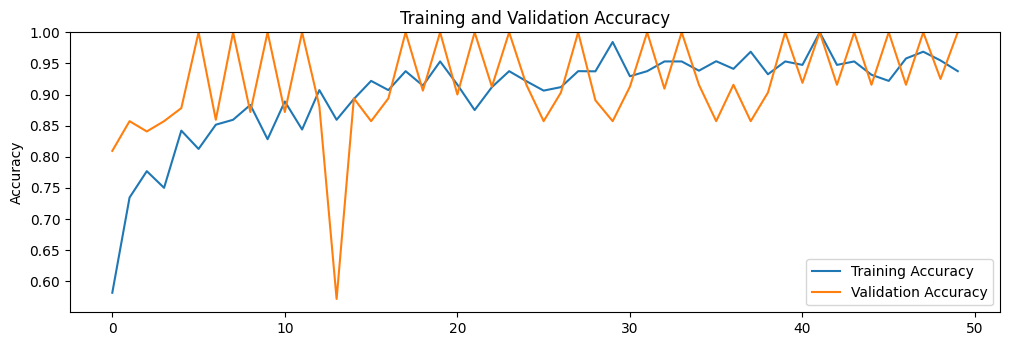

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

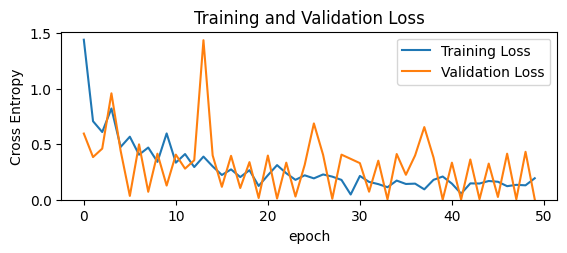

In [ ]:
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
# Load kembali model terbaik untuk prediksi
# Prediksi contoh gambar
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Lokasi folder testing
TEST_DIR = '/content/drive/My Drive/Capstone_Dataset_Batik/Test'

# Memuat model terbaik
save_path = '/content/drive/My Drive/Capstone_Dataset_Batik/model/classification_batik_model_grayscale.h5'
best_model = load_model(save_path)

# Mendapatkan daftar kelas dari nama subfolder dalam test_dir
classes = [subdir for subdir in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, subdir))]

# Melakukan pengujian untuk setiap kelas
for class_name in classes:
    class_dir = os.path.join(TEST_DIR, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Mengambil satu gambar secara acak dari setiap kelas
    if len(image_files) > 0:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)

        # Memuat dan memproses gambar
        img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Memprediksi kelas gambar
        prediction = best_model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = classes[predicted_class_index]

        # Menampilkan hasil prediksi
        print(f"Image: {random_image}")
        print(f"True Class: {class_name}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {np.max(prediction):.2%}")
        print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: insang.7.jpg
True Class: insang
Predicted Class: insang
Confidence: 99.62%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: test.kawung.14.jpg
True Class: kawung
Predicted Class: kawung
Confidence: 99.85%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: megamendung.8.jpg
True Class: mega mendung
Predicted Class: mega mendung
Confidence: 94.69%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: test.parang.20.jpg
True Class: parang
Predicted Class: parang
Confidence: 99.99%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: sidoluhur.17.jpg
True Class: sidoluhur
Predicted Class: sidoluhur
Confidence: 99.82%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: test.tumpal.12.jpg
True Class: tumpal
Predicted Class: tumpal
Confidence: 98.76%
---


In [ ]:
def predict_batik_pattern(model_path, image_path):
    # Load model
    model = load_model(save_path)

    try:
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = train_generator.class_indices
        predicted_class = {v: k for k, v in predicted_class.items()}[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        # Print results
        print("\nPrediction Results:")
        print("-" * 50)
        print(f"Image Path: {image_path}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")

        # Print all class probabilities
        print("\nAll Class Probabilities:")
        print("-" * 50)
        for class_name, prob in zip(predicted_class.values(), predictions[0]):
            print(f"{class_name}: {prob:.2%}")

    except Exception as e:
        print(f"Error occurred: {str(e)}")

# Example usage
model_path = 'classification_batik_model.h5'
image_path = '/content/drive/My Drive/Capstone_Dataset_Batik/Val/sidoluhur.jpg'

predict_batik_pattern(model_path, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prediction Results:
--------------------------------------------------
Image Path: /content/drive/My Drive/Capstone_Dataset_Batik/Val/sidoluhur.jpg
Predicted Class: parang
Confidence: 63.16%

All Class Probabilities:
--------------------------------------------------
Error occurred: 'str' object has no attribute 'values'
